In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Energy.HelpFunctions.get_energy_data import get_energy_data, prepare_data

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
df = get_energy_data()
df = prepare_data(df)

  0%|          | 0/255 [00:00<?, ?it/s]/Users/elias/Desktop/PTSFC/Energy/HelpFunctions/get_energy_data.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=col_names)])
100%|██████████| 255/255 [00:37<00:00,  6.76it/s]


In [5]:
def split_time(df, num_years = 0, num_months = 0, num_weeks = 0, num_days = 0, num_hours = 0):
    # date_to_keep = df.index.max() - num_years - num_months - num_days
    split_date = df.index.max() - pd.DateOffset(years = num_years, months=num_months, weeks = num_weeks, days=num_days, hours = num_hours)
    df_b = df.loc[df.index <= split_date]
    df_a = df.loc[df.index > split_date]
    
    return df_b, df_a

In [6]:
df

,gesamt,weekday
date_time,,
2018-12-24 00:00:00,42.02925,0
2018-12-24 01:00:00,39.61025,0
2018-12-24 02:00:00,39.13875,0
2018-12-24 03:00:00,39.42100,0
2018-12-24 04:00:00,40.74775,0
...,...,...
2023-11-12 16:00:00,50.67675,6
2023-11-12 17:00:00,53.91725,6
2023-11-12 18:00:00,54.42975,6


In [7]:

from Energy.Baseline.baseline import baseline

baseline(df, LAST_IDX=-1)

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2023-11-14 09:00:00,energy,36 hour,55.482969,60.624375,62.786000,66.530125,73.461894
1,2023-11-14 13:00:00,energy,40 hour,56.128937,60.919125,63.391625,66.730187,73.285125
2,2023-11-14 17:00:00,energy,44 hour,54.504819,57.848562,60.317750,65.865813,73.418131
3,2023-11-15 09:00:00,energy,60 hour,56.869331,60.910313,62.613500,66.459375,74.734387
4,2023-11-15 13:00:00,energy,64 hour,57.461419,61.153125,63.809500,66.546562,74.103850
5,2023-11-15 17:00:00,energy,68 hour,55.216300,57.658875,60.539750,65.769062,74.586944


# Cross validate

In [8]:
from datetime import datetime, timedelta


def most_recent_thursday(df):
    today = df.index.max()
    days_to_thursday = (today.weekday() - 3) % 7  # Calculate days to the most recent Thursday
    recent_thursday = today - timedelta(days=days_to_thursday, hours=today.hour, minutes=today.minute, seconds=today.second, microseconds=today.microsecond)
    
    # Set the time to 12:00 AM
    most_recent_thursday = recent_thursday.replace(hour=0, minute=0, second=0, microsecond=0)
    
    return most_recent_thursday




Remove everything til last thursday night 12pm

In [9]:
start_date_excl = most_recent_thursday(df)
df_cval = df.loc[df.index < start_date_excl]

In [10]:
baseline(df_cval, LAST_IDX=-1)

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2023-11-10 12:00:00,energy,36 hour,53.274763,60.872563,63.616750,67.128563,74.963481
1,2023-11-10 16:00:00,energy,40 hour,50.642019,55.814688,58.537500,62.717125,71.090000
2,2023-11-10 20:00:00,energy,44 hour,49.348806,52.384937,56.379125,60.121625,67.135544
3,2023-11-11 12:00:00,energy,60 hour,47.477200,51.317125,53.837750,57.298625,63.596281
4,2023-11-11 16:00:00,energy,64 hour,44.081156,47.382188,50.045750,53.573437,62.625650
5,2023-11-11 20:00:00,energy,68 hour,43.284444,46.577937,49.405625,53.355125,59.913819


Repeatedly run the model. Record predictions and true values (observations). Make sure the observations are available for the most recent prediction.

In [41]:
from Energy.HelpFunctions.calc_score import evaluate_horizon

# import importlib
# importlib.reload(Energy.Baseline)

evaluation = pd.DataFrame()
df_before = df_cval
for w in range(100):
    # Create a temp df that only contains the values used for training
    df_before, df_after = split_time(df_before, num_weeks=1)
    pred = baseline(df_before, LAST_IDX=-1)
    # Transform the observations to timeseries with same index and then merge
    obs = pd.DataFrame({'gesamt': df_cval.loc[pred['forecast_date']]["gesamt"]})
    obs = obs.rename_axis('forecast_date')
    pred = pred.set_index('forecast_date')
    # print(pred.iloc[0]['q0.025','q0.25'])
    merged_df = pd.merge(pred, obs, left_index=True, right_index=True) 
    
    # Add scores to the merged_df
    for index, row in merged_df.iterrows():
        quantile_preds = row[['q0.025','q0.25','q0.5','q0.75','q0.975']]
        observation = row['gesamt']
        score = evaluate_horizon(quantile_preds, observation)
        merged_df.at[index, 'score'] = score
    # print(merged_df[['q0.025','q0.25','q0.5','q0.75','q0.975']])
    evaluation = pd.concat([evaluation, merged_df])
    

In [42]:
evaluation

,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975,gesamt,score
forecast_date,,,,,,,,,
2023-11-03 12:00:00,energy,36 hour,53.274763,60.872563,63.616750,67.496313,75.325700,65.95400,6.751672
2023-11-03 16:00:00,energy,40 hour,50.642019,55.814688,58.537500,63.074937,71.603694,61.48775,7.628459
2023-11-03 20:00:00,energy,44 hour,49.348806,52.384937,56.379125,60.497062,67.426706,58.61850,7.199332
2023-11-04 12:00:00,energy,60 hour,47.477200,51.317125,53.837750,57.682688,63.793750,55.63325,5.794109
2023-11-04 16:00:00,energy,64 hour,44.081156,47.382188,50.045750,53.573437,63.037831,54.13450,9.254334
...,...,...,...,...,...,...,...,...,...
2021-12-10 16:00:00,energy,40 hour,49.422063,58.959750,61.605000,66.756438,72.169269,72.00400,25.929829
2021-12-10 20:00:00,energy,44 hour,49.794556,55.053125,59.819375,63.881313,66.994919,65.66425,14.684862
2021-12-11 12:00:00,energy,60 hour,51.602300,54.199938,55.887000,59.868625,63.831612,63.54050,18.443059


In [43]:
evaluation[evaluation['horizon'] == '36 hour']

,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975,gesamt,score
forecast_date,,,,,,,,,
2023-11-03 12:00:00,energy,36 hour,53.274763,60.872563,63.616750,67.496313,75.325700,65.95400,6.751672
2023-10-27 12:00:00,energy,36 hour,53.274763,60.872563,63.616750,68.005250,75.325700,66.15400,7.206141
2023-10-20 12:00:00,energy,36 hour,53.274763,60.872563,63.616750,68.005250,75.325700,69.16975,12.550891
2023-10-13 12:00:00,energy,36 hour,53.274763,60.872563,63.616750,68.295063,75.325700,65.68725,6.884297
2023-10-06 12:00:00,energy,36 hour,53.274763,60.872563,63.616750,68.334312,75.325700,64.72350,5.940172
...,...,...,...,...,...,...,...,...,...
2022-01-07 12:00:00,energy,36 hour,50.738319,63.703250,66.714000,70.733125,73.924913,73.27550,16.320517
2021-12-31 12:00:00,energy,36 hour,50.738319,63.846187,66.769000,70.795625,73.924913,56.43350,29.794923
2021-12-24 12:00:00,energy,36 hour,50.738319,64.077875,66.801375,70.935063,73.924913,59.74025,20.324298


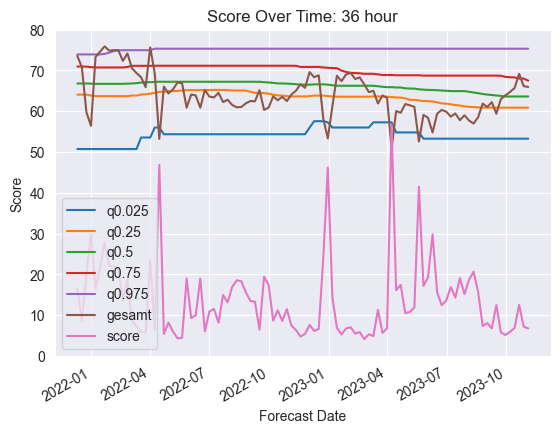

In [54]:
import matplotlib.pyplot as plt

horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']

# for h in horizons:

ax = evaluation[evaluation['horizon'] == '36 hour'].plot(kind='line',  linestyle='-')

# Adding labels and title
plt.xlabel('Forecast Date')
plt.ylabel('Score')
plt.title('Score Over Time: ' + '36 hour')
ax.set_ylim(0, 80)
# Display the plot
plt.show()








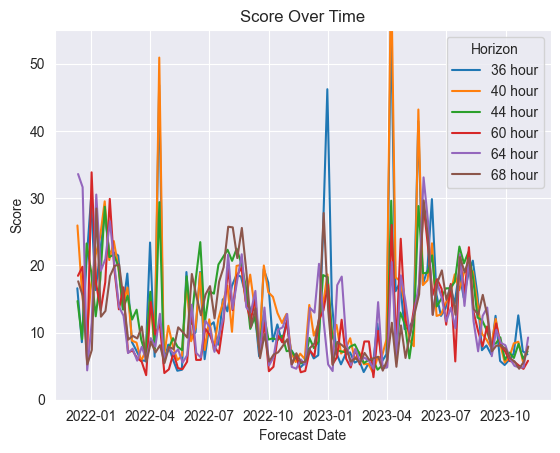

In [69]:
import matplotlib.pyplot as plt

# List of horizons
horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']

# Plotting all lines in one plot
plt.figure()  # Create a new figure
for h in horizons:
    subset = evaluation[evaluation['horizon'] == h]
    plt.plot(subset.index, subset['score'], label=h)

# Adding labels and title
plt.xlabel('Forecast Date')
plt.ylabel('Score')
plt.title('Score Over Time')

# Setting y-axis limit
plt.ylim(0,55)

# Adding legend
plt.legend(title='Horizon')

# Display the plot
plt.show()

It can be seen that the heavy outliers are 36 and 44 hour. Is it due to workdays (where production is still active) or not active?
==> CHeck for Holydays

YES! The orange outliers seem to be on Karfreitag.

It can also be seen, that 60-68 hour-forecasts seem to have less extreme outliers